In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [5]:
#hide
Path.BASE_PATH = path

In [6]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [7]:
# the jpgs are under images/breedX_123.jpg
# apparently breedX if capitalized it's a cat, ex: Bombay
# and if breedX is not cap'd then it's a dog, ex: beagle
# we can use regex to help make the y_labels for these images
(path/"images").ls()

(#7393) [Path('images/Bombay_174.jpg'),Path('images/boxer_193.jpg'),Path('images/saint_bernard_64.jpg'),Path('images/great_pyrenees_27.jpg'),Path('images/beagle_160.jpg'),Path('images/Russian_Blue_77.jpg'),Path('images/Birman_30.jpg'),Path('images/Siamese_146.jpg'),Path('images/Egyptian_Mau_189.jpg'),Path('images/saint_bernard_145.jpg')...]

In [8]:
fname = (path/"images").ls()[0]

In [9]:
# so here we find the breed name from the first file under /images using regex
re.findall(r'(.+)_\d+.jpg$', fname.name)
# this regex means...
# findall <- grabs all the chars that's found within ()
# r       <- don't treat \ as special char
# (.+)    <- grab all the letters before _\d+
# d+      <- afer underscore we can get any number of dgits
# .jpg    <- as is
# $       <- end of string


['Bombay']

In [10]:
re.findall(r'(.+)_\d+.jpg$', "american_eskimo_123.jpg")

['american_eskimo']

In [11]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


## Presizing

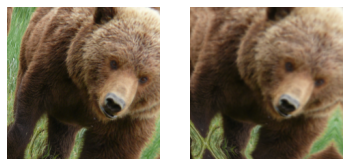

In [12]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

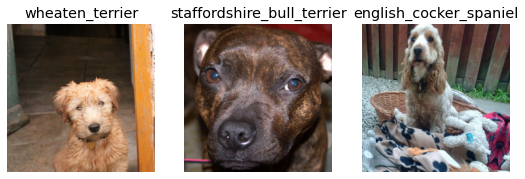

In [13]:
dls.show_batch(nrows=1, ncols=3)

In [14]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

# This will throw RuntimeError bc tensors sizes don't match...
# Error! It's not possible to collate your items in a batch
# Could not collate the 0-th members of your tuples because got the following shapes
# torch.Size([3, 375, 500]),torch.Size([3, 375, 500]),torch.Size([3, 270, 240]),torch.Size([3, 500, 333])

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/jupyter/.fastai/data/oxford-iiit-pet/images/Bombay_73.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/jupyter/.fastai/data/oxford-iiit-pet/images/Bombay_73.jpg
    applying partial gives
      Bombay
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(3))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_it

RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 500] at entry 0 and [3, 270, 240] at entry 2

In [15]:
# Here we did't bother to specify a loss fcn
# Why? bc fastAI will pick one for us!

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

# bc this has image data & a categorical outcome, fastai deided on CrossEntrophLoss
learn.loss_func

epoch,train_loss,valid_loss,error_rate,time
0,1.464258,0.391982,0.128552,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.475951,0.348347,0.116373,00:57
1,0.306502,0.256719,0.083897,00:58


FlattenedLoss of CrossEntropyLoss()

## Cross-Entropy Loss

In [ ]:
# Cross entropy loss is a loss fcn which is similar to the loss fcn we used in prev chaper.
# 2 benefits:
#     1. Works even when our dep vars has more than 2 categories (not just yes/no, but what breed)
#     2. it results in faster & more reliable training
    


### Viewing Activations and Labels

In [34]:
# grab 1 batch from dls training set
x,y = dls.one_batch()
print(f"x is a tensor image\ny labels = {y}")
print(dls.vocab)
print(f"...^ dls.vocab shows {len(dls.vocab)} breeds")

# btw this does the same thing
x2,y2 = first(dls.train)

x is a tensor image
y labels = TensorCategory([33, 20, 28, 34, 22,  7, 29,  3, 15,  9, 12, 11, 17, 31, 16, 13, 28, 33, 24, 21,  5, 17, 16,  8, 29,  5, 22,  6,  1,  6,  2, 17,  8, 20, 36, 15, 31, 10,  5, 35, 30, 26, 14, 36,  2, 14, 10, 13,
        28, 10, 27, 23, 21,  7, 20, 33,  2, 18,  9, 13, 22, 25, 18, 17], device='cuda:0')
['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
...^ dls.vocab shows 37 breeds


In [29]:
seq_of_batches = [(x,y),(x2,y2)]
preds,_ = learn.get_preds(dl=seq_of_batches)
preds[0], preds[1]

(TensorBase([2.1788e-09, 1.0772e-10, 3.6866e-07, 2.9777e-10, 1.4103e-08, 8.2642e-10, 7.7318e-08, 3.6732e-07, 2.2471e-08, 2.6273e-08, 6.9175e-09, 7.3782e-09, 2.2151e-09, 1.4098e-09, 1.2397e-09, 1.0300e-09,
         3.7000e-09, 1.2808e-08, 1.1751e-10, 3.4186e-08, 2.0535e-09, 8.6775e-09, 1.9312e-08, 7.0592e-09, 9.9998e-01, 1.2439e-06, 4.9926e-10, 1.8814e-07, 1.3393e-05, 1.0940e-07, 4.6003e-10, 3.9211e-06,
         5.4735e-08, 1.0421e-07, 2.9301e-08, 8.4614e-09, 5.6497e-09]),
 TensorBase([3.3043e-06, 4.9758e-06, 4.0519e-08, 1.5050e-06, 3.5550e-08, 2.9624e-06, 1.8870e-06, 5.6569e-08, 6.6636e-08, 5.5251e-06, 7.4635e-07, 9.9997e-01, 2.1690e-06, 6.9305e-07, 9.3129e-08, 4.8340e-08,
         4.5919e-07, 3.5296e-06, 2.1250e-07, 5.6752e-08, 1.1261e-07, 6.3146e-09, 1.5825e-08, 9.8042e-07, 1.3779e-08, 7.9956e-09, 2.1732e-07, 5.4174e-09, 4.0466e-08, 1.3993e-07, 5.8280e-09, 1.5614e-07,
         3.9390e-06, 5.9885e-07, 7.2939e-09, 3.7944e-08, 2.8580e-07]))

In [38]:
# each prediction comes back w/ likelihood for each of the 37 breeds, they should add u to 1
print(len(preds[0]),preds[0].sum())
print(len(preds[1]),preds[1].sum())

# BUT how does the model come up with these nums so they add up to 1?
# bc of an activation fcn in the model called SOFTMAX


37 TensorBase(1.)
37 TensorBase(1.0000)


### Softmax

/opt/conda/lib/python3.7/site-packages/fastbook/__init__.py:72: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


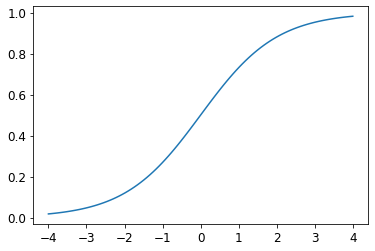

In [35]:
# See this sigmoid fcn returns y between 0 and 1?
# Basically we have 1 of these ACTIVATION FCNs for each of the 37 breeds
plot_function(torch.sigmoid, min=-4,max=4)

In [40]:
#hide
torch.random.manual_seed(42);

In [41]:
# So for the is-this-a-3-or-7? model seen before, we could just have 2 activation fcns
# an activation for 3, and another activation for 7

acts = torch.randn((6,2))*2
acts
# the tensor printouts below...
# 1st column are the activations for 3-ness, the 2nd column is the activation fro 7-ness


tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [42]:
# ... These do NOT add up to 1 though
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [43]:
# ... so we need to take the difference, and sigmoid that, 
# which returns the RELATIVE likelihood that it's the 1st column (3-ness)
(acts[:,0] - acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [44]:
# ... OR use softmax(), to get the RELATIVE likelihood of each category being the answer
sm_acts = torch.softmax(acts, dim=1)
sm_acts
# Now col1 + col2 = 1 yesssss

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [46]:
# k, how to extend that to more than 2 columns tho? we have 37 breeds!
def softmax_dupe(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

# softmax is the multi-category equiv of sigmoid
# Use it anytime we have 2+ categories, && the probabilities of all catgs must add to 1.
# We could create other fcns that have the properties that all activations are within 0 to 1, and sum to 1.
# However, no other fcn has the same relationship to the sigmoid fcn, which we see is smooth & symmetric.
# Also, softmax fcn works great w/ the loss fcn we'll look at later.

# exp grows fast, so softmax REALLY wants to pick 1 class among the others.
# not always what we want tho, sometimes we don't want it to match.


### Log Likelihood

In [52]:
# pretend these are our targets/answerKeys
targ = tensor([0,1,0,1,1,0])

In [53]:
# reusing example from earlier
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [54]:
### COOL INDEXING TRICK!!!

# now index my targets/answerKeys into the sm_activations
idx = range(6)
sm_acts[idx, tar]
# returned tensor shows i=0 actv picked, then i=1, then i=0, then 1, 1, 0
    # ideally we'd want these likelihoods to all be high, since they're on the answer labels
    
# Guess what?! this indexing is the same as the torch.where()!!!
        # activ_tensor[which_row, which_col_to_return]
        # does the SAME thing as torch.where() in mnist_loss!!
        # except with this we can use have more than just 2 categoreis :-D

# def mnist_loss(inputs, targets):
#     inputs = inputs.sigmoid()
#     return torch.where(targets==1, 1-inputs, inputs).mean()

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [57]:
# now plot out our fake predictions & fake target/answerKey

from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['result'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

# below we have the targ column for the answer key
# and result column is again, the predicted likelihood for the actual correct label

# btw, if we were to do all digits, then we'd be indexing into 10 cols/categories in sm_acts

3,7,targ,idx,result
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [58]:

-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [59]:
# guess what?! PyTorch provides a fcn that does the same thing as sm_acts[range(n), targ]
# except it takes the neg, bc when applying the log aftewars, we'll have neg nums

# nll = Negative Log Likelihood
        # but there's NO LOG in this, just wacky jargons
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
# nll is pretty good loss fcn, but torch.log can be better!

In [60]:
# ELI5 logarithms
y = b**a
a = log(y,b)

log(a*b) = log(a) + log(b)
# useful bc log(a*b) can get HUGE/TINY, hurts precision
# so breaking it down into 2+ parts is good

SyntaxError: can't assign to function call (3348904582.py, line 5)

#### Taking the Log

Recall that cross entropy loss may involve the multiplication of many numbers.  Multiplying lots of negative numbers together can cause problems like [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) in computers.  Therefore, we want to transform these probabilities to larger values so we can perform mathematical operations on them.  There is a mathematical function that does exactly this: the *logarithm* (available as `torch.log`). It is not defined for numbers less than 0, and looks like this between 0 and 1:

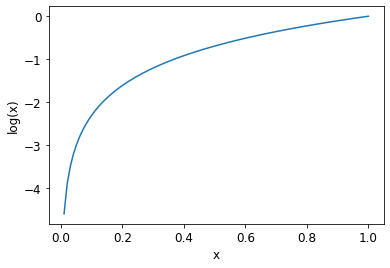

In [61]:
plot_function(torch.log, min=0,max=1, ty='log(x)', tx='x')

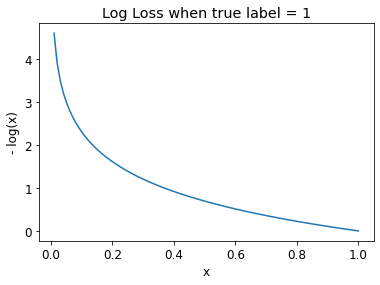

In [62]:
plot_function(lambda x: -1*torch.log(x), min=0,max=1, tx='x', ty='- log(x)', title = 'Log Loss when true label = 1')

In [63]:
from IPython.display import HTML
df['loss'] = -torch.log(tensor(df['result']))
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,result,loss
0.602469,0.397531,0,0,0.602469,0.506720
0.502065,0.497935,1,1,0.497935,0.697285
0.133188,0.866811,0,2,0.133188,2.015990
0.996640,0.003360,1,3,0.003360,5.695763
0.595949,0.404051,1,4,0.404051,0.906213
0.366118,0.633882,0,5,0.366118,1.004798


### Negative Log Likelihood

In [68]:
# when we first take the softmax, then the nll of that
# that combo is called CROSS ENTROPY LOSS

# guess what?! in PyTorch, this is avail as nn.CrossEntropyLoss
# which does log_softmax, then nll_loss

# then why doesn't nll_loss not take the log then? why is it softmax doing it?
# convenience, that's why
# nll_loss "inherits" the log from the log_softmax predecessor step

loss_func = nn.CrossEntropyLoss()
loss_func(acts, targ)

tensor(1.8045)

In [69]:
# or can call it this way
F.cross_entropy(acts, targ)

tensor(1.8045)

In [72]:
# the one above takes the mean, 
# but if u want to see all the losses, then add reduction=none

nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

In [71]:
(0.5067 + 0.6973 + 2.0160 + 5.6958 + 0.9062 + 1.0048)/6

1.8044666666666667

## Model Interpretation

In [ ]:
WEEK 4 VIDEO STOPPED HERE

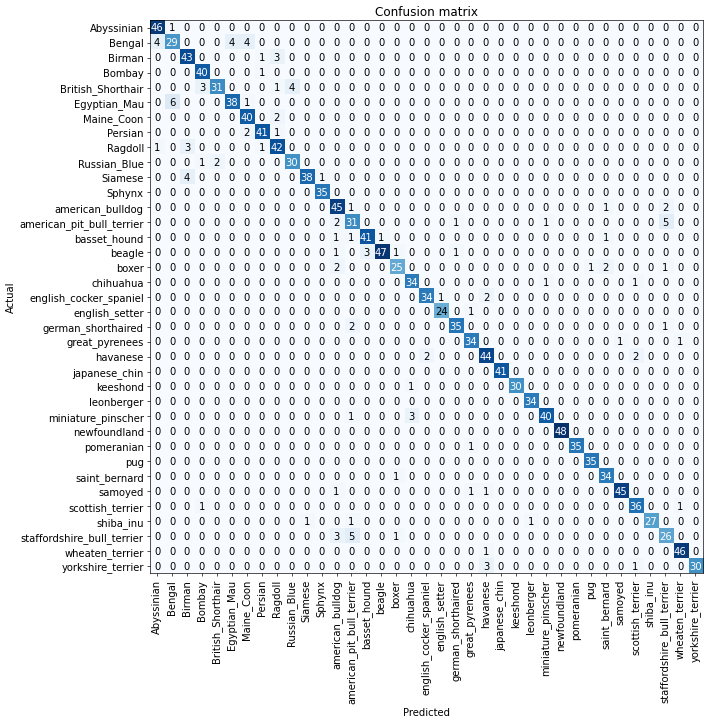

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [74]:
interp.most_confused(min_val=5)

[('Egyptian_Mau', 'Bengal', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

## Improving Our Model

### The Learning Rate Finder

In [75]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.663684,5.372067,0.478349,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.864605,2.337430,0.661028,00:56


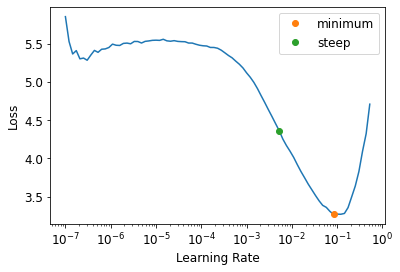

In [76]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [77]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 5.25e-03


In [78]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.311259,0.375289,0.119080,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.523119,0.494522,0.137348,00:57
1,0.324693,0.284778,0.092016,00:57


### Unfreezing and Transfer Learning

In [79]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


In [80]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.101084,0.361157,0.113667,00:45
1,0.512323,0.305413,0.101489,00:44
2,0.314667,0.259322,0.083897,00:45


In [81]:
learn.unfreeze()

SuggestedLRs(valley=4.365158383734524e-05)

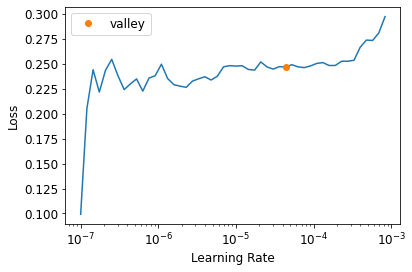

In [82]:
learn.lr_find()

In [83]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.251307,0.249803,0.079161,00:57
1,0.247778,0.253685,0.081191,00:57
2,0.224249,0.238787,0.077808,00:57
3,0.198544,0.240719,0.071719,00:57
4,0.188079,0.235585,0.070365,00:57
5,0.182213,0.235523,0.071719,00:57


### Discriminative Learning Rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.103934,0.380033,0.117727,00:45
1,0.506557,0.269629,0.086604,00:45
2,0.314397,0.244767,0.075778,00:45


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.